In [1]:
from musc.nn.sparse_coder import MUSC
from musc.nn.dictionary import TransposedUDictionary
import torch
from matplotlib import pyplot as plt
from functools import partial
from musc.nn.utils import get_all_conv_and_transpose_conv

compute_nnz_ratio = lambda aa: torch.count_nonzero(aa) / torch.numel(aa)

def av_channel_squared_mean(code):
  channel_squared_mean = torch.mean(code, [0, 2, 3]) ** 2
  return channel_squared_mean.mean().item()

def av_channel_variance(code):
  channel_var = torch.var(code, [0, 2, 3])
  return channel_var.mean().item()

In [2]:
musc_model = MUSC(kernel_size=3,
     hidden_layer_widths=[512, 256, 128, 64, 32],
     n_classes=1,
     ista_num_steps=8,
     lasso_lambda_scalar_list= [0.0, 0.0, 0.0, 0.0, 0.0], #[0.0, 0.0, 0.0, 0.01, 0.1],
     nonneg_code_bool=True)

In [10]:
# torch.nn.functional.relu(musc_model.ista_stepsize_iter_list)

In [3]:
with torch.no_grad():
  z = torch.randn(4, 1, 128, 128)
  D = musc_model.encoder_dictionary
  Dt = TransposedUDictionary(musc_model.encoder_dictionary)  # D^{\top}
  Dtz = Dt(z)  # D^{\top}z

  all_steps_alphas = []
  for step in range(musc_model.ista_num_steps):
    if step == 0:
      # \alpha <= D^{\top}z
      alphas = Dtz
    else:
      # \alpha <= \alpha + D^{\top}z - D^{\top}D \alpha
      DtDalphas = Dt(D(alphas))
      for scale in range(musc_model.num_scales):
        # alphas[scale] = alphas[scale] + Dtz[scale] - DtDalphas[scale]
        alphas[scale] = alphas[scale] + Dtz[scale] - DtDalphas[scale]

    all_steps_alphas.append([torch.clone(a) for a in alphas])
    for scale in range(musc_model.num_scales):
      alphas[scale] = musc_model.thres_operator(
        alphas[scale],
        lambd=musc_model.lasso_lambda_iter_list[step * musc_model.num_scales + scale])


acsm_all_steps_all_scales = []
acv_all_steps_all_scales = []
for step in range(musc_model.ista_num_steps):
  acsm_single_step_all_scales = []
  acv_single_step_all_scales = []
  for scale in range(musc_model.num_scales):
    code = all_steps_alphas[step][scale] #Dt(z)[code_idx] #
    acsm = av_channel_squared_mean(code)
    acv = av_channel_variance(code)
    acsm_single_step_all_scales.append(acsm)
    acv_single_step_all_scales.append(acv)
  acsm_all_steps_all_scales.append(acsm_single_step_all_scales)
  acv_all_steps_all_scales.append(acv_single_step_all_scales)

acsm_all_steps_all_scales = torch.Tensor(acsm_all_steps_all_scales)
acv_all_steps_all_scales = torch.Tensor(acv_all_steps_all_scales)

In [4]:
acv_all_steps_all_scales

import pandas as  pd

df_acv = pd.DataFrame(acv_all_steps_all_scales.numpy())

df_acv.index = [f'step-{str(step+1)}' for step in range(musc_model.ista_num_steps)]
df_acv.columns = [f'scale-{str(scale+1)}' for scale in range(musc_model.num_scales)]
df_acv = df_acv.style.set_caption("Average Channel Variance")

df_acv


,scale-1,scale-2,scale-3,scale-4,scale-5
step-1,0.000976,0.001127,0.002347,0.004995,0.011959
step-2,0.000909,0.001046,0.002175,0.004632,0.011042
step-3,0.002675,0.003072,0.006390,0.013605,0.032310
step-4,0.008583,0.009832,0.020430,0.043410,0.102462
step-5,0.029656,0.033872,0.070280,0.148899,0.349038
step-6,0.108266,0.123326,0.255513,0.539705,1.257228
step-7,0.410039,0.466078,0.964491,2.031815,4.709429
step-8,1.588810,1.803082,3.727990,7.836741,18.097387


In [5]:

df_acsm = pd.DataFrame(acsm_all_steps_all_scales.numpy())

df_acsm.index = [f'step-{str(step+1)}' for step in range(musc_model.ista_num_steps)]
df_acsm.columns = [f'scale-{str(scale+1)}' for scale in range(musc_model.num_scales)]
df_acsm = df_acsm.style.set_caption("Average Channel Mean Squared")

df_acsm

,scale-1,scale-2,scale-3,scale-4,scale-5
step-1,0.000003,0.000001,0.000001,0.000000,0.000000
step-2,0.000611,0.000713,0.001490,0.003183,0.007530
step-3,0.002441,0.002859,0.005983,0.012783,0.029962
step-4,0.009768,0.011459,0.024022,0.051300,0.119442
step-5,0.039108,0.045932,0.096420,0.205744,0.476706
step-6,0.156597,0.184077,0.386855,0.824697,1.904035
step-7,0.627060,0.737545,1.551535,3.304143,7.608811
step-8,2.510764,2.954455,6.220310,13.233043,30.416096


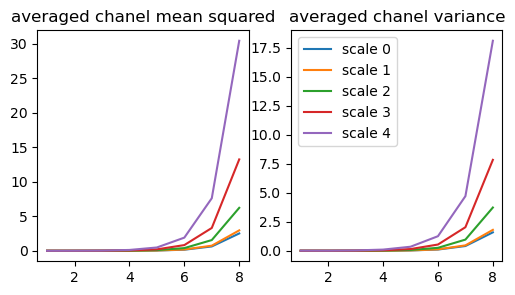

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

for scale in range(musc_model.num_scales):
  axes[0].plot(list(range(1, musc_model.ista_num_steps + 1)),
    acsm_all_steps_all_scales[:, scale], label=f'scale {scale}')
axes[0].set_title('averaged chanel mean squared')

for scale in range(musc_model.num_scales):
  axes[1].plot(list(range(1, musc_model.ista_num_steps + 1)),
    acv_all_steps_all_scales[:, scale], label=f'scale {scale}')
axes[1].set_title('averaged chanel variance')

plt.legend()
# acv_all_steps_all_scales

In [7]:
torch.nn.functional.softplus(torch.tensor(0.6))

tensor(1.0375)